In [1]:
# Load packages

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import os

# Conda packages used for virtual environment:
# pandas numpy geopandas rasterio contextily fiona ipykernel matplotlib seaborn xarray geowombat rasterstats os

## Getting Geospatial Data

In [2]:
# Import 2024 Congressional data

# Unzip Congressional district shapefile data

path = "../data_2023/2024_us_cd119"

if not os.path.exists(path):
    with zipfile.ZipFile("./data_2023/cb_2024_us_cd119_5m.zip", "r") as zip_ref:
        zip_ref.extractall("./data_2023/2024_us_cd119")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

Unzipped folder already exists. Skipping extraction.


In [3]:
# Get congressional district spatial data
gdf_cd = gpd.read_file("../data_2023/2024_us_cd119/cb_2024_us_cd119_5m.shp")

# Filter to Ohio only
gdf_cd = gdf_cd[gdf_cd['STATEFP'] == '39']

# Limit to specified columns
columns_gdf_cd = ['CD119FP', 'GEOID', 'geometry']
gdf_cd = gdf_cd[columns_gdf_cd]

# Preview
print(gdf_cd.head())

    CD119FP GEOID                                           geometry
34       06  3906  POLYGON ((-81.84486 39.45022, -81.82576 39.449...
137      13  3913  POLYGON ((-81.68780 41.02566, -81.68762 41.062...
138      02  3902  POLYGON ((-84.31524 39.05734, -84.31481 39.061...
200      09  3909  MULTIPOLYGON (((-82.73280 41.60432, -82.72107 ...
212      15  3915  POLYGON ((-84.43257 40.19704, -84.43396 40.270...


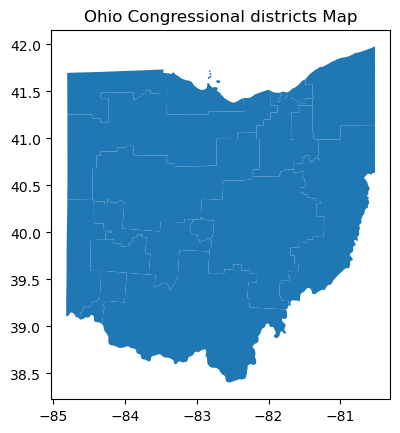

In [4]:
# Reprojecting to epsg:4326

gdf_cd_proj = gdf_cd.to_crs(epsg=4326)

# Map reprojected data
gdf_cd_proj.plot()
plt.title("Ohio Congressional districts Map")
plt.show()

In [5]:
gdf_cd_proj['CD119'] = 'Ohio ' + gdf_cd_proj['CD119FP']
gdf_cd_proj.head()

,CD119FP,GEOID,geometry,CD119
34,06,3906,"POLYGON ((-81.84486 39.45022, -81.82576 39.449...",Ohio 06
137,13,3913,"POLYGON ((-81.68780 41.02566, -81.68762 41.062...",Ohio 13
138,02,3902,"POLYGON ((-84.31524 39.05734, -84.31481 39.061...",Ohio 02
200,09,3909,"MULTIPOLYGON (((-82.73280 41.60432, -82.72107 ...",Ohio 09
212,15,3915,"POLYGON ((-84.43257 40.19704, -84.43396 40.270...",Ohio 15


### 2024 Land Coverage data

Data gathered from https://www.mrlc.gov/

Files were too large so had to be deleted from computer.

In [8]:
# Get land coverage data

# Unzip Ohio area land coverage data
path = "../data_2023/land_coverage_2024"

if not os.path.exists(path):
    with zipfile.ZipFile("../data_2023/land_coverage_2024.zip", "r") as zip_ref:
        zip_ref.extractall("../data_2023/land_coverage_2024")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

Unzipped successfully.


In [9]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from shapely.geometry import mapping

# Get land coerage data
tif_path = "../data_2023/land_coverage_2024/Annual_NLCD_LndCov_2024_CU_C1V1_5XThINakJJirSfO95Aar.tiff"

# Reproject land coverage data onto ESPG: 4326
dst_crs = 'EPSG:4326'
reprojected_tif_path = "../data_2023/land_coverage_reprojected.tif"

with rasterio.open(tif_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

# Create new reprojected .tif file called: land_coverage_reprojected.tif
    with rasterio.open(reprojected_tif_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


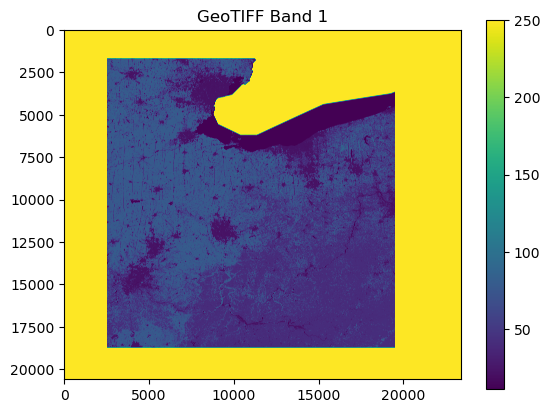

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open("../data_2023/land_coverage_reprojected.tif") as src:
    image = src.read(1)  # Read the first band

# Preview to ensure reprojection was successful (optional)
plt.imshow(image)
plt.colorbar()
plt.title("GeoTIFF Band 1")
plt.show()

In [14]:
# Get land coverage .tif file
raster_path = "../data_2023/land_coverage_reprojected.tif"

# Get geometry data for each congressional district
urbanization_cd_gdf = gdf_cd_proj.copy()
# cd_geom.head(20)

# Make sure they have the same projection
with rasterio.open("../data_2023/land_coverage_reprojected.tif") as src:
    print(src.crs)
    print(urbanization_cd_gdf.crs)

EPSG:4326
EPSG:4326


In [15]:
from rasterstats import zonal_stats

# Get pixel value counts per district
stats = zonal_stats(
    vectors=urbanization_cd_gdf,
    raster=raster_path,
    stats=None,  # no mean/sum, just raw counts
    categorical=True,
    nodata=0  # exclude nodata pixels (adjust if your nodata value is different)
)


In [16]:
# Add stats to the GeoDataFrame
urbanization_cd_gdf["dev_21"] = [s.get(21, 0) for s in stats]
urbanization_cd_gdf["dev_22"] = [s.get(22, 0) for s in stats]
urbanization_cd_gdf["dev_23"] = [s.get(23, 0) for s in stats]
urbanization_cd_gdf["dev_24"] = [s.get(24, 0) for s in stats]

# Add total developed area (pixel count)
urbanization_cd_gdf["dev_total"] = urbanization_cd_gdf[["dev_21", "dev_22", "dev_23", "dev_24"]].sum(axis=1)

# Total land pixels per district
urbanization_cd_gdf["total_pixels"] = [sum(s.values()) for s in stats]

# Calculate % developed for a measure of urbanization
urbanization_cd_gdf["urbanization_pct"] = (urbanization_cd_gdf["dev_total"] / urbanization_cd_gdf["total_pixels"]) * 100

urbanization_cd_gdf.head(20)


,CD119FP,GEOID,geometry,CD119,dev_21,dev_22,dev_23,dev_24,dev_total,total_pixels,urbanization_pct
34,06,3906,"POLYGON ((-81.84486 39.45022, -81.82576 39.449...",Ohio 06,1212682,663851,257043,67405,2200981,15366355,14.323377
137,13,3913,"POLYGON ((-81.68780 41.02566, -81.68762 41.062...",Ohio 13,465241,456711,234875,69612,1226439,2024743,60.572576
138,02,3902,"POLYGON ((-84.31524 39.05734, -84.31481 39.061...",Ohio 02,1450037,667190,203237,48430,2368894,23233054,10.196223
200,09,3909,"MULTIPOLYGON (((-82.73280 41.60432, -82.72107 ...",Ohio 09,377640,878857,365044,114846,1736387,8682720,19.998192
212,15,3915,"POLYGON ((-84.43257 40.19704, -84.43396 40.270...",Ohio 15,337009,496577,300953,96746,1231285,6140781,20.050951
222,11,3911,"POLYGON ((-81.85595 41.41903, -81.85222 41.418...",Ohio 11,120344,162585,236809,102504,622242,701393,88.715171
253,08,3908,"POLYGON ((-84.82016 39.22722, -84.81981 39.244...",Ohio 08,459838,537617,233055,66676,1297186,5682430,22.828015
273,03,3903,"POLYGON ((-83.10299 40.06130, -83.09337 40.062...",Ohio 03,110877,217846,209245,61651,599619,697195,86.004489
283,14,3914,"POLYGON ((-81.48892 41.62675, -81.48864 41.631...",Ohio 14,899348,586753,234046,62961,1783108,8030378,22.204534
372,01,3901,"POLYGON ((-84.70727 39.13250, -84.70677 39.132...",Ohio 01,325292,311607,189049,66501,892449,1914177,46.623118


In [ ]:
# Export data
urbanization_cd_gdf.to_csv('../data_2023/urbanization_2024.csv', index=False)